### Neural Networks: Essential Components and Using a Framework


In [1]:
# !pip install -U spacy==3.*
# !python -m spacy download en_core_web_sm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In this demo, we're once again going to use the **20 newgroups** dataset.<br>
https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
<br><br>


In [3]:
# Download the *train* dataset without headers, footers, and quotes to make the problem more challenging.
train_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [29]:
train_corpus['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [40]:
train_corpus['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Tokenization

We're going to use **Tensorflow/Keras** to build our model, but stick with spaCy for text preprocessing. While Keras does come with a basic tokenizer, it lacks spaCy's useful, specialist linguistic features.
<br><br>
To that end, we'll load the small English statistical model and create a tokenizer function as we did in the previous demos. We'll also disable named entity recognition and parsing since we don't need them.

In [4]:
# We don't need named entity recognition nor parsing. Removing them will speed up processing.
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [5]:
def spacy_tokenizer(doc):
  return [t.lemma_.lower() for t in nlp(doc) if \
          len(t) > 2 and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.is_alpha]

The function below takes some text, runs it through the spaCy tokenizer, then _joins_ the tokens back into a string using a '|' separator. The reason why we're doing this is further below.

In [6]:
def preprocess_text(text):
  tokens = spacy_tokenizer(text)
  return "|".join(tokens)

Next, we'll preprocess each post in the training corpus. In the [topic modelling demo](https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_topic_modelling_lda.ipynb#scrollTo=6siL9mNJxqix), we used **nlp.pipe** to preprocess batches of sentences at a time over multiple processes to speed things up. We'll keep it simple here and preprocess each post sequentially which will take longer.<br><br>
We'll end up with a collection of posts where each token is delimited with '|'.

In [7]:
%%time
preprocessed_train_corpus = [preprocess_text(post) for post in train_corpus.data]

CPU times: total: 14min 45s
Wall time: 17min 45s


In [8]:
print(preprocessed_train_corpus[0])
print(preprocessed_train_corpus[1])

wonder|enlighten|car|see|day|door|sport|car|look|late|early|call|bricklin|door|small|addition|bumper|separate|rest|body|know|tellme|model|engine|spec|year|production|car|history|info|funky|look|car|mail
fair|number|brave|soul|upgrade|clock|oscillator|share|experience|poll|send|brief|message|detail|experience|procedure|speed|attain|cpu|rate|speed|add|card|adapter|heat|sink|hour|usage|day|floppy|disk|functionality|floppy|especially|request|summarize|day|add|network|knowledge|base|clock|upgrade|answer|poll|thank


As before, we'll split the corpus into a training set and validation set.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [19]:
print(len(train_data), len(val_data))

9616 1698


At this point, we'll bring in **Keras**. Keras is a deep-learning framework built on top of Tensorflow, and makes it easy to compose models and iterate fast. Most of the time, Keras will provide everything you need but you can drop down to Tensorflow directly for more low-level customization.<br>
https://keras.io/<br>
https://www.tensorflow.org/
<br><br>
There's also **PyTorch** from Meta which is also excellent, popular, and has greater mindshare in research. You can't go wrong with either one.<br>
https://pytorch.org/<br><br>
Both have similar features and even syntax, so don't get caught up in framework wars:<br> https://twitter.com/soumithchintala/status/1263854044289929221
<br><br>
As an aside, the word _tensor_ in Tensorflow simply refers to a mathematical object. It's a generalization of scalars and vectors.  A scalar is a zero-rank tensor, a vector is a first-rank tensor, and so on.<br>
https://www.tensorflow.org/guide/tensor

We're going to use Keras' basic tokenizer to split our posts into sequences of tokens with no further processing.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Here, we're initializing a tokenizer to do nothing but split text on the '|' character. We're also including an Out-of-Vocabulary token **('OOV')**. Recall that during testing or inference, it's possible for our model to encounter words it didn't see during training. When that happens, the new word is fed into the model as an **'OOV'** token.

In [30]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')

Calling _fit_on_texts_ generates an internal vocabulary.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts

In [31]:
tokenizer.fit_on_texts(train_data)

We can look at the tokenizer's internals using the _get_config_ method.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#get_config
<br><br>
We can see information such as how many documents were processed to generate the vocabulary, the frequency of each token, and various indices. Btw--_num_words_ does NOT mean the number of words in the vocabulary. It's actually a parameter we can pass to the tokenizer upon initialization to keep the most frequent {_num_words_} words and to dump the rest. Here, we didn't set any limit.

In [32]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '|',
 'char_level': False,
 'oov_token': 'OOV',
 'document_count': 9616,
 'word_counts': '{"sorry": 295, "followup": 49, "email": 685, "address": 706, "try": 1770, "decide": 372, "printer": 250, "like": 3489, "hear": 846, "user": 673, "question": 1448, "thank": 1299, "xrpc": 1, "package": 562, "year": 2395, "believe": 1373, "get": 1897, "export": 163, "anybody": 355, "big": 649, "electron": 29, "noah": 6, "rob": 101, "butera": 1, "ask": 1108, "book": 861, "call": 1022, "lose": 439, "years": 8, "jesus": 682, "elizabeth": 8, "clare": 3, "prophet": 62, "know": 3850, "miss": 277, "leader": 173, "group": 1017, "church": 445, "universal": 52, "triumphant": 3, "derive": 62, "found": 48, "ballard": 4, "begin": 360, "mission": 213, "write": 1129, "memory": 453, "detail": 331, "straight": 143, "old": 865, "account": 246, "check": 577, "library": 315, "bnook": 1, "marcus": 6, "bach": 8, "eighteenth": 4, "century": 154, "frenchman": 1,

To get the size of the vocabulary, we can view the number of entries in *word_index*.

In [33]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 45379


## Vectorization

The next step is to vectorize our text with a basic (i.e. binary, count, TF-IDF) bag-of-words (BoW) approach. We learned about basic BoW in part one:<br>
https://www.nlpdemystified.org/course/basic-bag-of-words
<br><br>


---


**NOTE:**<br>
Now that we understand how neural networks work, there are **MUCH** better ways to vectorize text than basic bag-of-words for neural network models. But since we haven't learned them yet and this demo is just to get a feel for building neural networks for NLP, we'll stick with BoW for now.


---



The Keras tokenizer's _texts_to_matrix_ method builds a BoW. It can create different BoW types including binary (default), TF-IDF, and others.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_matrix

In [34]:
# Vectorize the first post using binary. We're using [:1] here because the
# tokenizer expects an *array* of sequences.
print(train_data[:1])

# The resulting binary BoW has a 1 set for every word present in the sequence.
binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['sorry|followup|email|address|try|decide|printer|like|hear|user|printer|question|thank']
Vector shape: (1, 45380)
[[0. 0. 0. ... 0. 0. 0.]]


We can retrieve the original tokens from the BoW by getting the indices which are set to 1, and then looking them up with the tokenizer's *index_word* dictionary.

In [35]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ".join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [   3   27   32   41   96  137  142  146  373  504  617 2591]
like try question thank hear address email user decide sorry printer followup


If we want TF-IDF vectors instead, we can get them by setting the *mode* parameter.

In [36]:
tfidf_bow = tokenizer.texts_to_matrix(train_data[:1], mode='tfidf')
print(tfidf_bow, '\n')

# https://numpy.org/doc/stable/user/basics.indexing.html
print(f"TF-IDF scores of the first post's tokens:\n {tfidf_bow[0][present_tokens]}")

[[0. 0. 0. ... 0. 0. 0.]] 

TF-IDF scores of the first post's tokens:
 [1.67181117 2.17534187 2.46233233 2.21592895 2.78892285 3.28251394
 3.19211311 3.59685722 3.51442517 3.5513158  7.48557896 5.43787225]


For simplicity, we'll stick to binary BoW. Feel free to experiment with different modes to see if you can squeeze better performance.

In addition to vectorizing the text into binary BoWs, we're going to also store them in Tensorflow **sparse matrices**. Our vocabulary is quite large and for each post, very few indices in each vector will be set to 1. This means we'll have large matrices of mostly zeros which is expensive to store and can be problematic for environments such as a free tier of Colab.
<br><br>
Tensorflow **sparse tensors** store these types of data structures more efficiently, and Keras can work seamlessly with them.<br>
https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor
<br><br>
We'll vectorize the training data using *texts_to_matrix* and turn the results into a **sparse tensor**.

In [37]:
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))

In the next module, we'll learn a vectorization technique to create smaller, _dense_ vectors that can pack more information beyond just simply indicating whether a word is present.

The shape of the tensor corresponds to the number of tokenized documents (rows) and vocabulary (columns).

In [38]:
X_train.shape

TensorShape([9616, 45380])

We also need to vectorize our labels. Since our goal is multiclass classification, we'll one-hot encode the labels. That is, each label vector will be an array of length 20 (corresponding to the 20 classes) with the index corresponding to the correct class set to 1. The rest will be zero.
<br><br>
Keras has a _to_categorical_ method to help with this.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [39]:
print(train_labels)

[ 2  5  4 ... 15  6  2]


In [41]:
y_train = keras.utils.to_categorical(train_labels)

The shape of the tensor corresponds to the number of documents (rows) and classes (columns)

Looking at the first entry in the vectorized labels, we can see its corresponding class.<br>
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

In [42]:
print(y_train.shape)
print(y_train[0])
print(f"Target/class: {train_corpus.target_names[np.argmax(y_train[0])]}")

(9616, 20)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target/class: comp.os.ms-windows.misc


We'll vectorize the validation data and labels as well.

In [43]:
X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

## Building an Initial Model

To build our models, we'll use Keras' **sequential** API which allows us to describe a model layer-by-layer, and provides training and inference features.<br>
https://keras.io/api/models/sequential/<br>
https://keras.io/guides/sequential_model/
<br><br>
The layers themselves are a bunch of classes which we can initialize with parameters such as number of units, which activation function to use, and more. There are a bunch of layers available we can use out-of-the-box and we can also create our own.
<br>
https://keras.io/api/layers/
<br><br>
We can alternatively use the **Functional** API for more flexibility but we'll stick with **Sequential** for now.<br>
https://keras.io/guides/functional_api/

We'll build a simple model with two hidden layers. The output layer uses **softmax** since we're performing multiclass classification.

In [44]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(0)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

After specifying the layers, we'll *compile* the model and specify which optimizer, loss function, and performance metric we want to use.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile<br>
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers<br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses<br>
https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [45]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Similar to our previous experience with Scikit-learn, we can train a Keras model by calling its _fit_ method and specifying a number of parameters. In this case, we're specifying number of epochs and batch size. We're also passing in our validation data on which the model will evaluate the loss after each epoch.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit

In [46]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/15
76/76 [==============================] - 5s 54ms/step - loss: 2.6715 - accuracy: 0.2654 - val_loss: 2.1492 - val_accuracy: 0.4229
Epoch 2/15
76/76 [==============================] - 3s 45ms/step - loss: 1.6414 - accuracy: 0.5932 - val_loss: 1.5456 - val_accuracy: 0.5383
Epoch 3/15
76/76 [==============================] - 4s 52ms/step - loss: 1.0394 - accuracy: 0.7348 - val_loss: 1.2773 - val_accuracy: 0.6266
Epoch 4/15
76/76 [==============================] - 4s 52ms/step - loss: 0.7094 - accuracy: 0.8158 - val_loss: 1.1941 - val_accuracy: 0.6437
Epoch 5/15
76/76 [==============================] - 4s 49ms/step - loss: 0.5020 - accuracy: 0.8706 - val_loss: 1.1464 - val_accuracy: 0.6708
Epoch 6/15
76/76 [==============================] - 3s 44ms/step - loss: 0.3683 - accuracy: 0.9101 - val_loss: 1.2031 - val_accuracy: 0.6667
Epoch 7/15
76/76 [==============================] - 3s 43ms/step - loss: 0.2802 - accuracy: 0.9345 - val_loss: 1.2492 - val_accuracy: 0.6696
Epoch 8/15
76

During training, our model outputted a history of loss and accuracy metrics for both the training set and validation set. We can see the training and validation metrics get better for a certain number of epochs before they start diverging. Performance on the training set keeps improving while performance on the validation set starts degrading at some point, signalling that the model is starting to overfit.
<br><br>
We can plot this information as well.

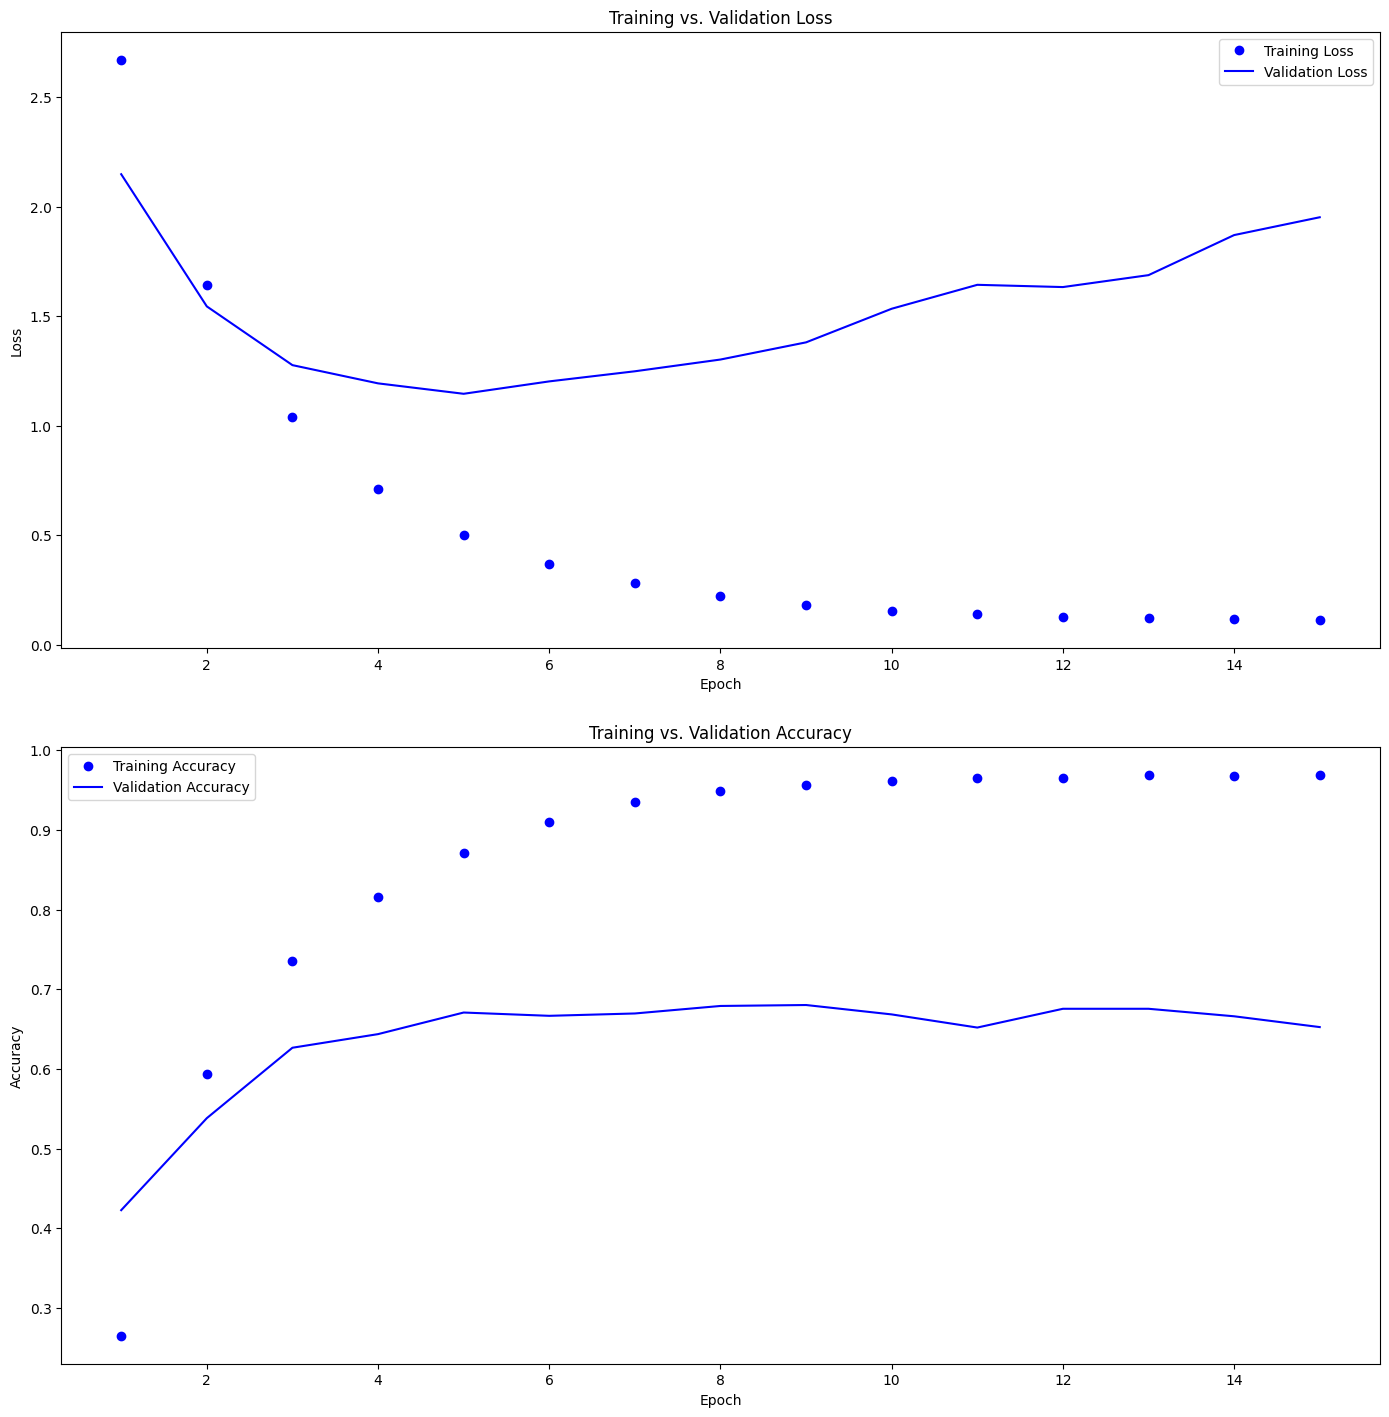

In [47]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Our current model, the way it's trained, has overfit on the data.
<br><br>
Since we have an idea of when that overfitting begins, we can now train a _new_ model that stops training at or right before that point. In the following cell, we'll retrain an identical model but this time with the number of epochs equalling the point where the divergence began in our previous model.


In [49]:
tf.random.set_seed(0)
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/5


76/76 [==============================] - 6s 63ms/step - loss: 2.6715 - accuracy: 0.2654 - val_loss: 2.1492 - val_accuracy: 0.4229
Epoch 2/5
76/76 [==============================] - 4s 50ms/step - loss: 1.6414 - accuracy: 0.5932 - val_loss: 1.5456 - val_accuracy: 0.5383
Epoch 3/5
76/76 [==============================] - 4s 57ms/step - loss: 1.0394 - accuracy: 0.7348 - val_loss: 1.2773 - val_accuracy: 0.6266
Epoch 4/5
76/76 [==============================] - 4s 52ms/step - loss: 0.7094 - accuracy: 0.8158 - val_loss: 1.1941 - val_accuracy: 0.6437
Epoch 5/5
76/76 [==============================] - 4s 53ms/step - loss: 0.5020 - accuracy: 0.8706 - val_loss: 1.1464 - val_accuracy: 0.6708


We can look at a summary of our model using the _summary_ method.


In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               5808768   
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 20)                2580      
                                                                 
Total params: 5827860 (22.23 MB)
Trainable params: 5827860 (22.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Looking at the preceding summary, there's an outsized number of parameters (i.e. weights) in the first layer because the BoW encoding results in a wide vocabulary array. This isn't great.
<br><br>
If you're wondering where that _param_ number comes from, here's how it's calculated:



In [51]:
# Size of vocabulary. The '+ 1' is because the zero index is reserved for padding.
v = (len(tokenizer.word_index) + 1)
print(f"Size of vocabulary/number of columns in BoW array (v): {v}")

n = NUM_UNITS
print(f"Number of units in the first layer(n): {n}\n")

# The '+ n' accounts for the number of biases. Each unit has one.
p = v * n + n
print(f"Number of params in the first layer(p) = v * n + n = {p}")

Size of vocabulary/number of columns in BoW array (v): 45380
Number of units in the first layer(n): 128

Number of params in the first layer(p) = v * n + n = 5808768


We can look at the weights in each layer as well using the _get_weights_ method. Here are the weights of the first layer. It's a two-element array where the first contains the non-bias weights and the second contains the bias weights.<br>
https://keras.io/api/layers/base_layer/#getweights-method

In [52]:
model.layers[0].get_weights()

[array([[ 0.00633252, -0.02465083,  0.03155954, ...,  0.05510619,
          0.0270196 ,  0.02357678],
        [-0.05220519, -0.05705109, -0.05572385, ..., -0.02488913,
         -0.00772499,  0.03230472],
        [-0.01113699, -0.03546195,  0.02410778, ...,  0.02441408,
          0.0898105 ,  0.07587738],
        ...,
        [ 0.03190077,  0.00849312,  0.08578092, ...,  0.03429086,
          0.07345039, -0.00791895],
        [-0.09061699, -0.0363147 ,  0.01158327, ...,  0.06285333,
         -0.03643426, -0.0352067 ],
        [-0.06344522, -0.02991827,  0.00758366, ...,  0.05164402,
          0.06166728,  0.04086035]], dtype=float32),
 array([0.08698938, 0.12033708, 0.09507091, 0.08628874, 0.10351467,
        0.0937728 , 0.11414573, 0.13348159, 0.14173599, 0.09890271,
        0.1092294 , 0.12046843, 0.08826715, 0.14673628, 0.09756979,
        0.10243637, 0.13423914, 0.11561907, 0.1336324 , 0.092321  ,
        0.11488922, 0.13941494, 0.11918233, 0.09835409, 0.10601933,
        0.10691006

And these are the weights from the first layer's first unit without the bias.

In [53]:
ws = model.layers[0].get_weights()[0][0]
print(len(ws))
ws

128


array([ 0.00633252, -0.02465083,  0.03155954, -0.03944233,  0.02841545,
       -0.07784969, -0.07214358,  0.01211157, -0.11347484,  0.05113735,
        0.02510856, -0.19483842,  0.05845584,  0.0089512 ,  0.0132828 ,
       -0.01544286,  0.09238126, -0.0490174 ,  0.09657896, -0.08423332,
        0.05498499, -0.03655428,  0.01454775, -0.04559011, -0.05393646,
       -0.02843217,  0.04433785, -0.03723487, -0.03797784, -0.04369315,
       -0.05825317, -0.01236771,  0.02006781,  0.02785707, -0.04004025,
        0.02495876,  0.01514242,  0.0972392 ,  0.02680153, -0.02578488,
       -0.01950794,  0.000305  ,  0.01816095, -0.0309119 , -0.01024365,
        0.07917755, -0.01968769,  0.00057877, -0.01045427,  0.05018104,
       -0.01685247,  0.04022045, -0.0784259 ,  0.00790154,  0.02111397,
        0.0410518 ,  0.01375475, -0.06683829,  0.01404174,  0.00986658,
        0.04986066, -0.01828479, -0.00456914, -0.00223281,  0.04473996,
       -0.01042102, -0.02548703,  0.05005852, -0.04727412,  0.01

Let's try our model on the test set. We'll download it without the metadata, preprocess it, then vectorize the inputs and targets.

In [54]:
test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [55]:
%%time
preprocessed_test_corpus = [preprocess_text(post) for post in test_corpus.data]

CPU times: total: 2min 4s
Wall time: 2min 8s


In [56]:
X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

Since we're evaluating the model on the test set, we'll use the _evaluate_ method.<br>
https://keras.io/api/models/model_training_apis/#evaluate-method

In [57]:
results = model.evaluate(X_test, y_test)

236/236 [==============================] - 1s 4ms/step - loss: 1.4645 - accuracy: 0.6038


_evaluate_ returns a two-element list with the loss as the first entry and the metric of interest as the second entry.

In [58]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 1.4645299911499023
Test accuracy: 0.6038236618041992


Random guessing would result in an accuracy of ~5% (since there are 20 classes and the data is balanced), so the results are much better than that. But it's still not very satisfying and it falls short of our naive bayes classifier.
<br><br>
Let's take a look at a confusion matrix and classification report. To generate those, we'll need the actual predictions from the model which we'll generate using the _predict_ method.
<br>
https://keras.io/api/models/model_training_apis/#predict-method

In [59]:
y_pred_probs = model.predict(X_test, verbose=1)

236/236 [==============================] - 1s 2ms/step


The output layer ends with a softmax, so each y_pred element is a **probability distribution**. We need to extract the most probable class. We can do that using numpy's *argmax*:<br>
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

In [60]:
print(f"Softmax for first post:\n {y_pred_probs[0]}\n")

# Get class with highest probability from each softmax output.
y_preds = np.argmax(y_pred_probs, axis=1)

print(f"Class with highest probability for first test post: {y_preds[0]}")
print(f"Text label: {train_corpus.target_names[y_preds[0]]}")

Softmax for first post:
 [3.3165779e-05 8.4136112e-04 6.0900883e-03 4.5295157e-02 1.3526100e-01
 1.5030413e-05 1.4298113e-02 7.7828813e-01 5.2222898e-03 1.9522582e-04
 5.5306277e-04 2.0989213e-05 6.9902553e-03 6.5715483e-04 5.7094549e-03
 5.9888916e-05 1.6807254e-04 6.7642927e-06 1.4661030e-04 1.4828023e-04]

Class with highest probability for first test post: 7
Text label: rec.autos


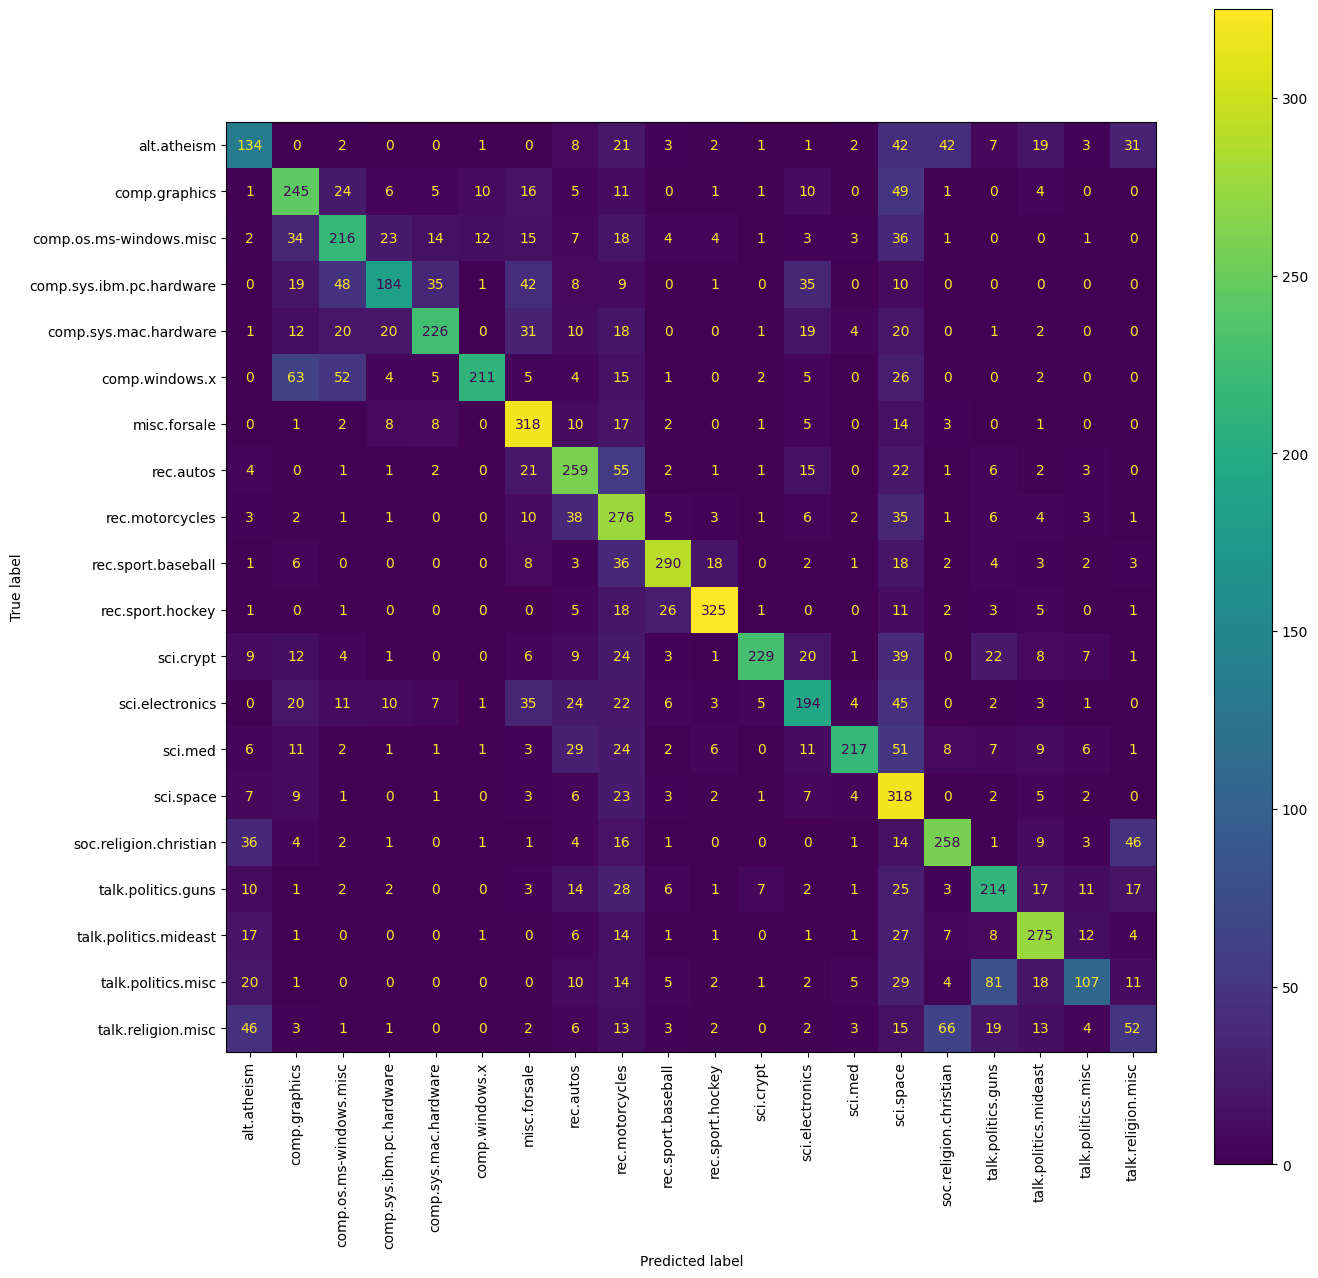

In [61]:
# Not normalizing this time. Just looking at raw numbers.
cm = confusion_matrix(test_corpus.target, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

A few observations:
- The same patterns from the naive bayes classifier can be seen here. There's a cluster of brighter squares around the technology-related subjects (pc.hardware, mac.hardware, electronics, etc), and subjects such as athiesm, christianity, guns, and politics are confused for each other which drag the overall accuracy down.
- The more focused topics have brighter diagonal squares.

In [62]:
print(classification_report(test_corpus.target, y_preds, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.45      0.42      0.43       319
           comp.graphics       0.55      0.63      0.59       389
 comp.os.ms-windows.misc       0.55      0.55      0.55       394
comp.sys.ibm.pc.hardware       0.70      0.47      0.56       392
   comp.sys.mac.hardware       0.74      0.59      0.66       385
          comp.windows.x       0.88      0.53      0.67       395
            misc.forsale       0.61      0.82      0.70       390
               rec.autos       0.56      0.65      0.60       396
         rec.motorcycles       0.41      0.69      0.52       398
      rec.sport.baseball       0.80      0.73      0.76       397
        rec.sport.hockey       0.87      0.81      0.84       399
               sci.crypt       0.91      0.58      0.71       396
         sci.electronics       0.57      0.49      0.53       393
                 sci.med       0.87      0.55      0.67       396
         

Let's take a look at some posts in a class with **low precision** and **high recall**.

In [65]:
# The class with low precision and high recall from the classification report.
class_of_interest = test_corpus.target_names.index('rec.sport.hockey')
class_of_interest

10

What we'll do here is:
1. Get the posts which were classified under this class.
2. Get ALL posts which are misclassified.
3. Get the posts which were misclassified under this class.

In [66]:
# Get the indices of posts which were classified under this class.
class_preds = np.where(y_preds == class_of_interest)[0]
print(class_preds)

[  56   61   63   72   85  106  134  140  144  146  158  165  176  178
  217  243  249  258  281  295  300  310  313  331  341  348  363  379
  418  421  516  520  529  554  558  581  594  601  602  614  643  654
  664  668  672  714  732  736  750  754  756  765  767  805  835  844
  854  859  861  862  885  892  901  915  930  935  943  955  983 1009
 1015 1018 1021 1024 1035 1048 1093 1137 1141 1158 1177 1216 1220 1222
 1226 1297 1304 1305 1321 1376 1424 1434 1542 1544 1569 1583 1658 1666
 1678 1679 1719 1760 1772 1783 1788 1793 1823 1825 1838 1897 1924 1963
 2044 2066 2097 2099 2108 2120 2136 2166 2178 2193 2204 2224 2281 2285
 2303 2312 2331 2352 2357 2393 2414 2443 2503 2554 2596 2632 2633 2634
 2643 2650 2732 2745 2753 2771 2781 2784 2815 2844 2848 2851 2859 2861
 2864 2912 2925 2926 2929 2940 2963 2966 2967 3003 3006 3019 3034 3083
 3102 3122 3192 3202 3216 3220 3276 3316 3334 3345 3384 3424 3452 3488
 3522 3530 3537 3550 3598 3609 3635 3650 3652 3676 3710 3730 3743 3756
 3765 

In [67]:
# Get the indices of misclassified posts.
misclassified_posts = np.nonzero(test_corpus.target != y_preds)[0]
print(misclassified_posts)

[   1    3    4 ... 7528 7529 7530]


We can get the posts misclassified under this class using:<br>
https://numpy.org/doc/stable/reference/generated/numpy.in1d.html

In [68]:
misclassified_specific = class_preds[np.in1d(class_preds, misclassified_posts)]
print(misclassified_specific)

[  63  165  249  421  516  901 1021 1137 1226 1297 1569 1783 2120 2178
 2281 2848 2851 2929 3006 3316 3537 3710 3963 4216 4350 4508 4554 4922
 5215 5306 5314 5342 5413 5432 5450 5600 5737 5740 6198 6275 6401 6488
 6652 6855 7256 7258 7349 7395]


Let's take a look at the content of a few of the posts misclassified under this class.

In [69]:
for post_idx in misclassified_specific[:10]:
  print("Predicted class: {}".format(test_corpus.target_names[y_preds[post_idx]]))
  print("Actual class: {}".format(test_corpus.target_names[test_corpus.target[post_idx]]))
  print("Post: {}".format(preprocessed_test_corpus[post_idx]))
  print()

Predicted class: rec.sport.hockey
Actual class: talk.religion.misc
Post: douglas|meier|play|electro|magnetic|golf|northwestern|university|acns|accord|rule|centrifugal|university|bumblepuppy|brave|new|world|lib|pinko|view

Predicted class: rec.sport.hockey
Actual class: rec.motorcycles
Post: glassboro|new|jersey

Predicted class: rec.sport.hockey
Actual class: rec.motorcycles
Post: ooooooh|complain|spelling|hurt|student|alumnus|employee|money|grub|bnr|huh|hope|permanent|waste|benefit|pthptptphhph

Predicted class: rec.sport.hockey
Actual class: rec.sport.baseball
Post: comment|delete|bandwidth|god|know|need|roger|question|run|expansion|team|team|moment|draft|come|go|pick|guy|win|ring|guy|contribute|team|reds|dumb|protect|larkin|jays|protect|alfredo|pick|believe|get|involve|john

Predicted class: rec.sport.hockey
Actual class: sci.electronics
Post: replay|thank|lot

Predicted class: rec.sport.hockey
Actual class: sci.med
Post: posting|past|allege|pathological|esp|neurological|condition|i

A number of these posts:
1. have just a handful of words such that they can't be classified.
2. are ambiguous with little context such that a human would have a hard time.

## Making Another Attempt

Before building another model, let's throw away any preprocessed posts with fewer than five words.

In [70]:
def filter_short_texts(text, min_len, split_char):
  tokens = text.split(split_char)
  return len(tokens) >= min_len

In [71]:
print('Number of training posts before filtering short texts: {}'.format(len(preprocessed_train_corpus)))

# Filter training corpus.
z = zip(preprocessed_train_corpus, train_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_train_corpus, train_corpus.target = zip(*f)

print('Number of training posts after filtering short texts: {}'.format(len(preprocessed_train_corpus)))

Number of training posts before filtering short texts: 11314
Number of training posts after filtering short texts: 10616


In [73]:
# Do the same for the test corpus.

print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

z = zip(preprocessed_test_corpus, test_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_test_corpus, test_corpus.target = zip(*f)

print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

Number of testing posts before filtering short texts: 7044
Number of testing posts before filtering short texts: 7044


In [74]:
# Resplit the training data into train/validation sets.
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [75]:
# Re-vectorize the training, validation, and test data.
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))
y_train = keras.utils.to_categorical(train_labels)

X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

For the next attempt, we'll add another dense layer and follow that with some **dropout** regularization. We'll also initialize with **He initialization**.<br>
https://keras.io/api/layers/regularization_layers/dropout/<br>
https://keras.io/api/layers/initializers/#layer-weight-initializers
<br><br>
We'll also leverage **early stopping** to halt training once our validation stops improving. This'll save us the trouble of manually training another model with fewer epochs as we did with the previous model. This is done through a **callback**. Here, the **patience** parameter specifies how many epochs to process with no improvement before training stops. Since we saw in the early graphs that validation loss diverges pretty sharply, we're setting it to 1. If you saw that validation tends to plateau for a bit before improving again, you could consider setting a higher value. There are other settings worth reading about as well.<br>
https://keras.io/api/callbacks/<br>
https://keras.io/api/callbacks/early_stopping/<br>



In [76]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

tf.random.set_seed(0)
initializer = tf.keras.initializers.HeNormal(seed=1)

model_next = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES, activation='softmax')
])

model_next.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_next.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[es_callback])

Epoch 1/15
71/71 [==============================] - 5s 55ms/step - loss: 1.9895 - accuracy: 0.4753 - val_loss: 1.1963 - val_accuracy: 0.7238
Epoch 2/15
71/71 [==============================] - 3s 46ms/step - loss: 0.7736 - accuracy: 0.8043 - val_loss: 0.9103 - val_accuracy: 0.7483
Epoch 3/15
71/71 [==============================] - 4s 51ms/step - loss: 0.3479 - accuracy: 0.9165 - val_loss: 0.9293 - val_accuracy: 0.7571


Evaluate the new model on the test set to see if there's any improvement.

In [77]:
results = model_next.evaluate(X_test, y_test)

221/221 [==============================] - 1s 3ms/step - loss: 1.2853 - accuracy: 0.6780


Get class predictions on the test set and view a confusion matrix.

221/221 [==============================] - 1s 3ms/step


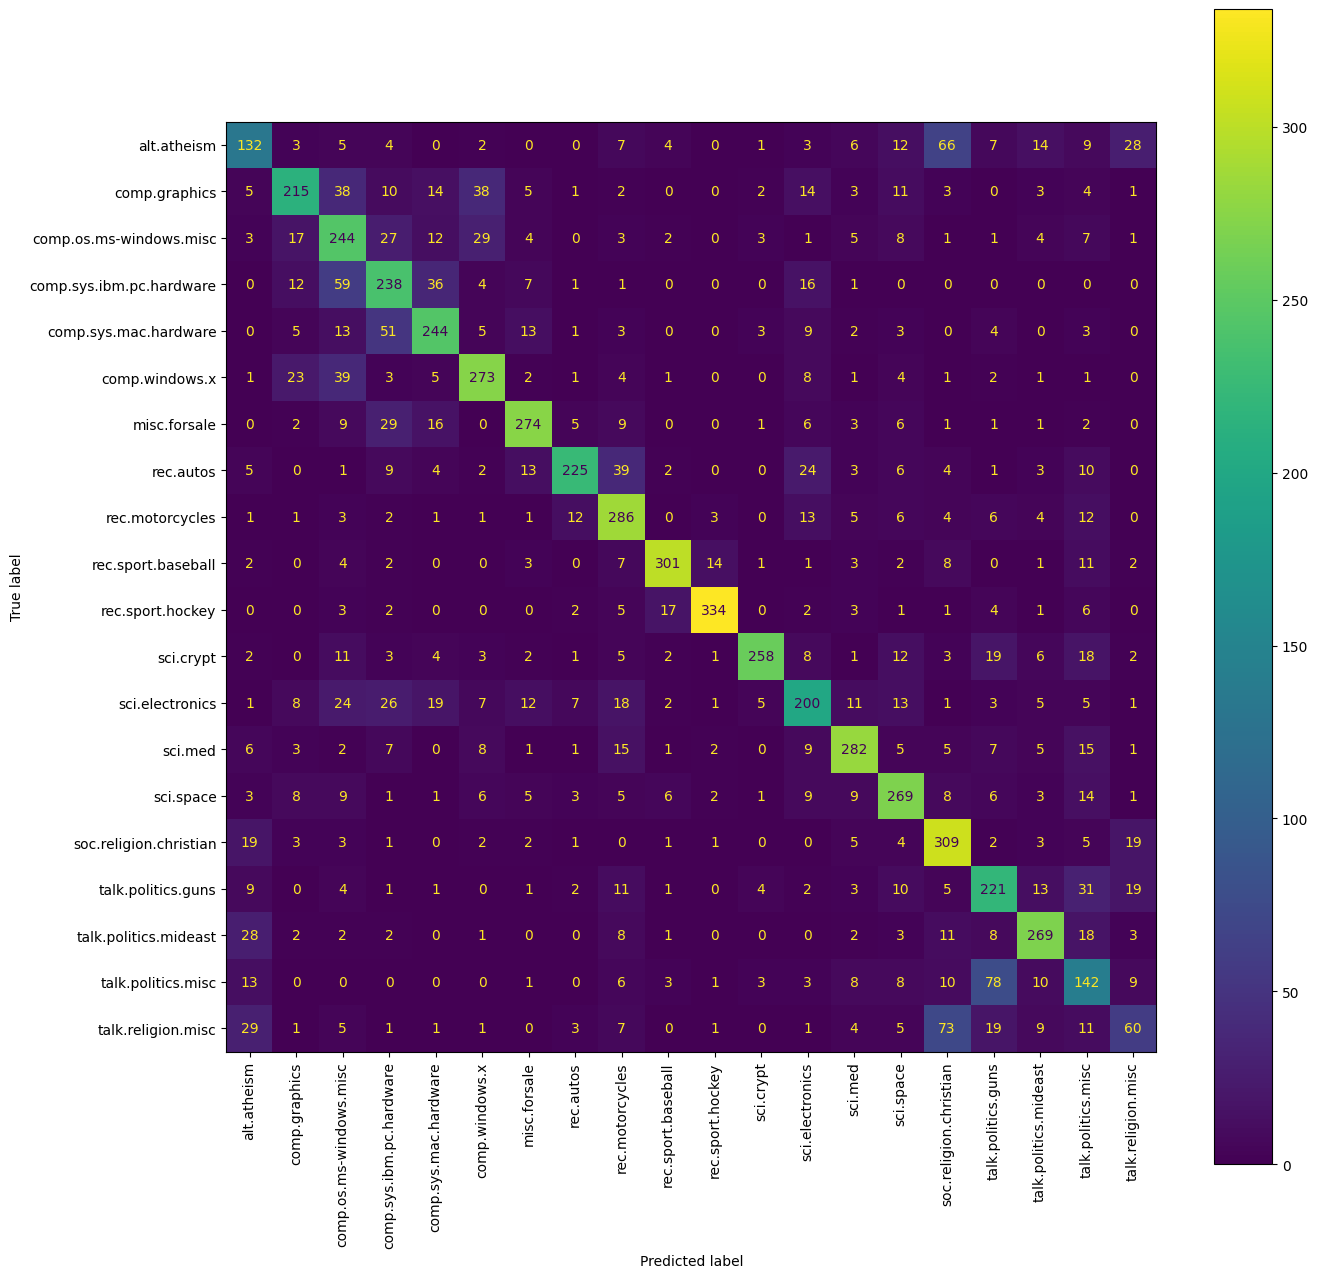

In [78]:
y_pred_probs = model_next.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Not normalizing this time. Just looking at raw numbers.
cm = confusion_matrix(test_corpus.target, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

Check out the classification report.

In [79]:
print(classification_report(test_corpus.target, y_pred, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.51      0.44      0.47       303
           comp.graphics       0.71      0.58      0.64       369
 comp.os.ms-windows.misc       0.51      0.66      0.57       372
comp.sys.ibm.pc.hardware       0.57      0.63      0.60       375
   comp.sys.mac.hardware       0.68      0.68      0.68       359
          comp.windows.x       0.71      0.74      0.73       370
            misc.forsale       0.79      0.75      0.77       365
               rec.autos       0.85      0.64      0.73       351
         rec.motorcycles       0.65      0.79      0.71       361
      rec.sport.baseball       0.88      0.83      0.85       362
        rec.sport.hockey       0.93      0.88      0.90       381
               sci.crypt       0.91      0.71      0.80       361
         sci.electronics       0.61      0.54      0.57       369
                 sci.med       0.78      0.75      0.77       375
         

Compared to the previous model, this improved model has lower loss, higher accuracy, and doesn't have any unusual discrepancies between precision and recall outside of the usual problematic classes (tech/religion/politics). It's now on par with our Naive Bayes classifier though it doesn't beat it. More on this below.

Let's use our improved model for some inference. The function below takes some text, tokenizes and vectorizes it, then returns the model's classification for it.

In [80]:
target_names = test_corpus.target_names.copy()

def classify_post(post):
  vectorized_post = tokenizer.texts_to_matrix([('|').join(spacy_tokenizer(post))])
  probs = model_next.predict(vectorized_post)
  pred = np.argmax(probs, axis=1)[0]
  return target_names[pred], probs[0][pred]

We'll test the model on a bunch of posts from Reddit.

In [81]:
# Post from r/medicine.
s = "New primary care attending here. Why are all my new patients age 60-80 yo on Ambien? Serious question, why? Was there a strong marketing push at this time frame? Was it given out like candy to anyone who said they had some trouble with sleep? Was there any discussion of risks and duration of therapy? Has anyone had success/tips for weaning them off of it?"
classify_post(s)

1/1 [==============================] - 0s 70ms/step


('sci.med', 0.9888075)

In [82]:
# Post from r/space.
s = "James Webb Space Telescope has successfully deployed its forward sunshield pallet! Next up: aft sunshield deployment"
classify_post(s)

1/1 [==============================] - 0s 53ms/step


('sci.space', 0.931909)

In [83]:
# Post from r/cars.
s = "Cars made in the last 10 years with a 4 Speed Manual Transmission? As per the title really, I’m wondering if any vehicles have been made in the last 10 years that still utilise a 4 speed (or less) manual transmission. My Google research has thus far not turned up any results."
classify_post(s)

1/1 [==============================] - 0s 39ms/step


('rec.autos', 0.934915)

In [84]:
# Post from r/electronics.
s = "This project is powered by an ATTiny85. Five of its pins were used, three of them for the MAX7219 module controling the 7-segment display and one for the button and piezo buzzer respectively. The user can give input through the button. A normal short press to count one up and a long 6-second press to reset it to 0. I also added a simple switch. The microcontroller stores the value in its EEPROM so it doesn't lose it when powered off. I used a charger of an old phone as a power supply. My dad was really excited when he got it for Christmas and it should certainly help him quit smoking :)"
classify_post(s)

1/1 [==============================] - 0s 37ms/step


('sci.electronics', 0.97863775)

So at this point, we have a model that roughly matches the performance of the naive bayes classifier. You could further experiment with a bunch of other things from what we learned:
- Use a different tokenizer mode (e.g. count or TF-IDF).
- Filter out words based on frequency (e.g. bottom and top 20%).
- Train with much more data.
- Use another optimizer.
- Use more layers (deeper network) or more units in a layer (wider network).
- Tweak the regularization.
<br><br>

That being said, it's going to be difficult to squeeze much more performance because:
- Stripped of metadata, a lot of these posts are ambiguous such that a human would have a hard time classifying them.
- Our BoW encoding is also subpar in that it's large but encodes no information beyond whether a word is present. Especially with the overlapping topics which drag the overall accuracy down, throwing away context makes it much harder to classify.
- Because our input vectors are extremely wide and sparse, we're forced to reduce it down aggressively to a manageable number of units in the first layer. If we were to have a first layer with 20,000 units for example (roughly half of the vocabulary size), that layer alone would have over 800 million parameters which is absurd for a problem of this nature.
<br><br>

But this dataset was used because, beyond putting what we learned into practice, it's a lesson that dirty/low-signal data and information loss during vectorization has a heavy influence on downstream work and performance. If the data is low-quality and the vectorization technique is subpar, then throwing more layers at the problem won't help.
<br><br>
In the rest of the course, we'll learn vectorization techniques which encode much more information in a much smaller space.

## Additional Reading
If you're curious about how to build a custom model using the low-level features of Tensorflow, here are a few links to work through:<br>
https://www.tensorflow.org/tutorials/customization/basics<br>
https://www.tensorflow.org/tutorials/customization/custom_layers<br>
https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough<br>
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit<br><br>

PyTorch Tutorials:<br>
https://pytorch.org/tutorials/beginner/basics/intro.html<br>
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html<br>
https://pytorch.org/tutorials/beginner/nn_tutorial.html

## Practice

Tensorflow comes with a number dataset loaders, one of which is a collection of ~11,000 Reuters news articles in 46 categories.
<br><br>
Retrieve the data, vectorize both the articles and labels, and build a model to classify the articles.

In [ ]:
from tensorflow.keras.datasets import reuters

In [ ]:
# Call the load_data method to retrieve the train and test sets. Explore the load_data
# method to see what options there are (e.g. limiting the number of words).
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
#
# NOTE: The load_data method doesn't return arrays of strings, but rather
# arrays of integers. Each news article is encoded as a sequence of integers. There's
# no need to tokenize. You can recreate the article using get_word_index.
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/get_word_index
#


In [ ]:
# Vectorize X_train and X_test (i.e. the articles) as some bag of words matrices.
# Maybe you can use the Keras Tokenizer?
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


In [ ]:
# Vectorize y_train and y_test (i.e. the labels) as one-hot/categorical encodings.


In [ ]:
# Create your model architecture here.
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  # Your layers here
])

In [ ]:
# Compile your model here specifying an optimizer, loss function, and performance metric.


In [ ]:
# Fit your model on your test set using early stopping. Optionally divide the test set
# into test/validation splits and pass the validation data to the fit method.


In [ ]:
# If you're satisfied, evaluate the model on the test set and see what you get.
